## 2nd variant
### Dynamic Bayesian Network Structure Learning with variational circuit.
This is an example with real test data and dummy generated training data of 86 variables, that means 172 vertices (86 for t and 86 for t+1).    
n_qubits=2 * ceil(log2(2 * nnodes)) -> for nnodes = 86, n_qubits = 16    
where first eight digits correspond to vertice where the edge begins and eight last digits correspond to vertice where edge ends i.e. 0000001000000101 corresponds to: vertice_2 ---> vertice_5  

It was tested with two sets of test data at the end of the notebook. The last test is with real data


In [1]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import torchvision
from torch import nn
import numpy as np
import pennylane as qml
import random
import networkx as nx
from matplotlib import pyplot as plt

In [2]:
path = "large_elu.csv"

In [3]:
ds = pd.read_csv(path)
ds

,vertices,experiment,t0,t1
0,v0,1,0.50,0.10
1,v1,1,0.03,0.45
2,v2,1,0.50,0.04
3,v3,1,0.60,0.80
4,v0,2,0.10,0.07
5,v1,2,0.45,0.10
6,v2,2,0.04,0.04
7,v3,2,0.80,0.50
8,v0,3,0.07,0.05
9,v1,3,0.10,0.06


In [ ]:
nnodes = 86
ds = ds.sort_values(by=['T', 'NAME'])
t01_list = [ds[['t0','t1']].iloc[f*nnodes:(f+1)*nnodes].values.T for f in range(len(ds)//nnodes)]
dst = pd.DataFrame({'T':range(len(ds)//nnodes), 't01':t01_list})
dst
nodes_names = {f:ds[['NAME']].iloc[0:nnodes].values[f][0] for f in range(nnodes)}
nodes_genes = {f:ds[['GENE']].iloc[0:nnodes].values[f][0] for f in range(nnodes)}

In [4]:
scale = np.frompyfunc(lambda x, min, max: (x-min)/(max - min), 3, 1)

def get_edges(n=4):
    num_edges = random.randint(n, n+3)
    e1 = [(random.randint(0, n-1),random.randint(0, (n*2)-1)) for f in range(num_edges//2)]
    e2 = [(random.randint(0, (n*2)-1),random.randint(n, (n*2)-1)) for f in range(num_edges//2)]
    return e1 + e2

def get_t0(edges, weights, n=4):
    t0 = np.zeros(n) + 0.01
    edges0 = [edge for i in range(n) for edge in edges if edge[0] == i and edge[1] < n]
    if len(edges0) > 0:
        t0[edges0[0][0]] = random.random()
        for edge in edges0:
            t0[edge[1]] += weights[edge[0]] + weights[edge[1]] * t0[edge[0]]
    return t0
        
def get_t1(edges, weights, t0, n=4):
    t1 = np.zeros(n) + 0.01
    edges1 = [edge for edge in edges if edge[1] >= n]
    for edge in edges1:
        if edge[0] < n:
            t1[edge[1]-n] += weights[edge[0]] + weights[edge[1]-n] * t0[edge[0]]
        else:
            t1[edge[1]-n] += weights[edge[0]-n] + weights[edge[1]-n] * t1[edge[0]-n]
    return t1

In [5]:
# generate training dataset
exper = 1000
n_qubits = 16
arr_list = []
edges_list = []
for f in range(exper):
    weights = [random.randint(1, 10)/10 for f in range(nnodes)]
    edges = get_edges(n = nnodes)
    t0 = get_t0(edges, weights, n = nnodes)
    t1 = get_t1(edges, weights, t0, n = nnodes)
    arr_list.append(scale(np.stack([t0,t1]),np.min(np.stack([t0,t1])), np.max(np.stack([t0,t1]))).astype(float))
    edges_list.append(edges)
arr = np.concatenate(arr_list, axis=1)

In [6]:
dsa = pd.DataFrame({'t01':arr_list})
dsa

,t01
0,"[[0.23630675964236098, 0.0, 0.1354762120623224..."
1,"[[0.0, 0.0, 0.0, 0.42431474922437873], [0.0, 0..."
2,"[[0.1941472403108588, 0.0, 0.0, 0.226283079982..."
3,"[[0.0, 0.027912727956422353, 0.0, 1.0], [0.0, ..."
4,"[[0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]]"
...,...
995,"[[0.0, 0.0, 0.0, 0.0], [0.834983498349835, 1.0..."
996,"[[0.0, 0.14883501826348658, 0.0, 0.63027640467..."
997,"[[0.0, 0.0, 0.0, 0.831874010486082], [1.0, 0.9..."
998,"[[0.0, 0.0, 0.28153094170921006, 0.36048423461..."


In [7]:
#int("110100010",2) = 418
edges_bin_list = [[np.binary_repr(ed[0], width=n_qubits//2) + np.binary_repr(ed[1], width=n_qubits//2)  for ed in edges] for edges in edges_list]
ya_list = [[int(edge,2) for edge in edges] for edges in edges_bin_list]

In [8]:
dsa['y'] = ya_list

In [9]:
dsa

,t01,y
0,"[[0.23630675964236098, 0.0, 0.1354762120623224...","[16, 4, 22, 5, 37, 12]"
1,"[[0.0, 0.0, 0.0, 0.42431474922437873], [0.0, 0...","[13, 27, 23, 23]"
2,"[[0.1941472403108588, 0.0, 0.0, 0.226283079982...","[15, 23, 24, 62, 61, 13]"
3,"[[0.0, 0.027912727956422353, 0.0, 1.0], [0.0, ...","[11, 21, 22, 37]"
4,"[[0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]]","[13, 5, 53, 13]"
...,...,...
995,"[[0.0, 0.0, 0.0, 0.0], [0.834983498349835, 1.0...","[28, 20, 23, 45]"
996,"[[0.0, 0.14883501826348658, 0.0, 0.63027640467...","[11, 23, 13, 44, 23, 14]"
997,"[[0.0, 0.0, 0.0, 0.831874010486082], [1.0, 0.9...","[29, 27, 6, 38, 12, 52]"
998,"[[0.0, 0.0, 0.28153094170921006, 0.36048423461...","[21, 19, 22, 29, 23, 31]"


In [10]:
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, eweights, weights):
    for i in range(nnodes):
        qml.Rot(inputs[i], inputs[i+nnodes], inputs[i+nnodes]-inputs[i], wires=i)
    for W in weights:
            for i in range(n_qubits):
                qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)

    qml.BasicEntanglerLayers(eweights, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

In [11]:
n_layers = 4
weight_shapes = {"weights": (n_layers, n_qubits, 3), "eweights": (n_layers, n_qubits)}

In [12]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [13]:
layers = [qlayer]
model = torch.nn.Sequential(*layers)

In [14]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
#criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [15]:
def error(predictions, y):
    error = np.sum(abs(y.detach().numpy() - predictions.detach().numpy()))/len(y[0].detach().numpy())
    return error

In [16]:
def get_ranks(outputs, y, weighted = False):
    rp = np.flip(np.argsort(outputs.detach().numpy()))
    if weighted:
        a = [np.argwhere(rp == x)[0][1]*outputs.detach().numpy()[0][x]*len(np.nonzero(y.detach().numpy())[1]) for x in np.nonzero(y.detach().numpy())[1]]
    else:
        a = [np.argwhere(rp == x)[0][1] for x in np.nonzero(y.detach().numpy())[1]]
    return a

def score(outputs, y, weighted = False):
    ly = len(np.nonzero(y.detach().numpy())[1])
    lo = len(y[0].detach().numpy())
    ranks = get_ranks(outputs, y, weighted)
    sr = sum(ranks)
    sy = sum(range(ly))
    sw = sum(range(lo-ly,lo))
    return 1 - (sr - sy)/(sw - sy) 

In [17]:
class CustomDataset(Dataset):
    def __init__(self, ds, n, q, transform=None):
        self.ds_full = ds
        self.n = n
        self.q = q
        self.x_csv = self.ds_full[["t01"]]
        self.y_csv = self.ds_full[["y"]]
        self.transform = transform

    def __len__(self):
        return len(self.x_csv)

    def __getitem__(self, idx):
        x = np.array(self.x_csv.iloc[idx].tolist())
        y = np.zeros(2**self.q)
        for i in self.y_csv.iloc[idx].tolist():
            #011000 24
            y[i] = 1/len(self.y_csv.iloc[idx].tolist()[0])
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        return x, y

In [18]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

train_dataset = CustomDataset(dsa, nnodes, n_qubits, transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False
)

In [19]:
%%time
epochs = 1
input_size=nnodes*2
for epoch in range(epochs):
    loss = 0
    err = 0
    metr = 0
    wmetr = 0
    for batch_features, y_batch in train_loader:
        batch_features = batch_features.view(-1, input_size)
        
        optimizer.zero_grad()
        
        outputs = model(batch_features)
        
        train_loss = criterion(outputs, y_batch)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()

        err += error(outputs, y_batch)

        metr += score(outputs, y_batch, False)

        wmetr += score(outputs, y_batch, True)

    loss = loss / len(train_loader)
 
    err = err / len(train_loader)
    
    metr = metr / len(train_loader)

    wmetr = wmetr / len(train_loader)
    
    print("epoch : {}/{}, loss = {:.6f}, error = {:.6f}, score = {:.6f}, weighted_score = {:.6f}".format(epoch + 1, 
                                                                                                        epochs, 
                                                                                                        loss, 
                                                                                                        err, 
                                                                                                        metr,
                                                                                                        wmetr))

epoch : 1/250, loss = 0.000003, error = 0.027951, acc = 0.551042
epoch : 2/250, loss = 0.000003, error = 0.027629, acc = 0.613202
epoch : 3/250, loss = 0.000003, error = 0.027496, acc = 0.642005
epoch : 4/250, loss = 0.000003, error = 0.027397, acc = 0.661374
epoch : 5/250, loss = 0.000003, error = 0.027327, acc = 0.674636
epoch : 6/250, loss = 0.000003, error = 0.027267, acc = 0.684860
epoch : 7/250, loss = 0.000003, error = 0.027228, acc = 0.689519
epoch : 8/250, loss = 0.000003, error = 0.027198, acc = 0.692130
epoch : 9/250, loss = 0.000003, error = 0.027178, acc = 0.694669
epoch : 10/250, loss = 0.000003, error = 0.027161, acc = 0.695848
epoch : 11/250, loss = 0.000003, error = 0.027153, acc = 0.697590
epoch : 12/250, loss = 0.000003, error = 0.027146, acc = 0.699013
epoch : 13/250, loss = 0.000003, error = 0.027146, acc = 0.698953
epoch : 14/250, loss = 0.000003, error = 0.027147, acc = 0.699890
epoch : 15/250, loss = 0.000003, error = 0.027132, acc = 0.700316
epoch : 16/250, los

KeyboardInterrupt: 

## testing with generated data

In [21]:
# generate Testing dataset
exper = 12
num_res = 12
arr_list = []
edges_list = []
edges = get_edges(n = nnodes)
for f in range(exper):
    weights = [random.randint(1, 10)/10 for f in range(nnodes)]
    t0 = get_t0(edges, weights, n = nnodes)
    t1 = get_t1(edges, weights, t0, n = nnodes)
    arr_list.append(scale(np.stack([t0,t1]),np.min(np.stack([t0,t1])), np.max(np.stack([t0,t1]))).astype(float))
    edges_list.append(edges)
arr = np.concatenate(arr_list, axis=1)

In [22]:
dstest = pd.DataFrame({'t01':arr_list})
dstest

,t01
0,"[[0.0, 0.0, 1.0, 0.8491314882347492], [0.35961..."
1,"[[0.0, 0.0, 1.0, 0.765024848697849], [0.232019..."
2,"[[0.0, 0.0, 0.4443346833135752, 0.193743948974..."
3,"[[0.0, 0.0, 0.16826787764631376, 0.11567008689..."
4,"[[0.0, 0.0, 1.0, 0.527307785813192], [0.333524..."
5,"[[0.0, 0.0, 1.0, 0.6388927303629873], [0.14872..."
6,"[[0.0, 0.0, 0.9792517228111817, 0.315774382082..."
7,"[[0.0, 0.0, 1.0, 0.5292448456690646], [0.33934..."
8,"[[0.0, 0.0, 1.0, 0.5399156322525304], [0.41970..."
9,"[[0.0, 0.0, 0.5947586373705717, 0.148797083709..."


In [23]:
#int("110100010",2) = 418
edges_bin_list = [[np.binary_repr(ed[0], width=n_qubits//2) + np.binary_repr(ed[1], width=n_qubits//2)  for ed in edges] for edges in edges_list]
ya_list = [[int(edge,2) for edge in edges] for edges in edges_bin_list]

In [24]:
dstest['y'] = ya_list
dstest

,t01,y
0,"[[0.0, 0.0, 1.0, 0.8491314882347492], [0.35961...","[19, 26, 5, 60]"
1,"[[0.0, 0.0, 1.0, 0.765024848697849], [0.232019...","[19, 26, 5, 60]"
2,"[[0.0, 0.0, 0.4443346833135752, 0.193743948974...","[19, 26, 5, 60]"
3,"[[0.0, 0.0, 0.16826787764631376, 0.11567008689...","[19, 26, 5, 60]"
4,"[[0.0, 0.0, 1.0, 0.527307785813192], [0.333524...","[19, 26, 5, 60]"
5,"[[0.0, 0.0, 1.0, 0.6388927303629873], [0.14872...","[19, 26, 5, 60]"
6,"[[0.0, 0.0, 0.9792517228111817, 0.315774382082...","[19, 26, 5, 60]"
7,"[[0.0, 0.0, 1.0, 0.5292448456690646], [0.33934...","[19, 26, 5, 60]"
8,"[[0.0, 0.0, 1.0, 0.5399156322525304], [0.41970...","[19, 26, 5, 60]"
9,"[[0.0, 0.0, 0.5947586373705717, 0.148797083709...","[19, 26, 5, 60]"


In [25]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

test_dataset = CustomDataset(dstest, nnodes, n_qubits, transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)


In [26]:
experiments = []
outputs_list = []
for batch_features, _ in test_loader:
    batch_features = batch_features.view(-1, input_size)
    batch_features
    outputs = model(batch_features)
    outputs_list.append(outputs)
    experiments.append(np.flip(np.argsort(outputs.detach().numpy())))

[array([[22, 23, 13, 15, 20,  3, 12, 24, 14, 54, 45, 21,  0, 27,  7, 25,
         39,  2,  1, 28, 60, 26,  9, 18, 47, 55,  6, 52,  5, 30, 31, 29,
         44,  4, 38, 17, 61, 46, 10, 16, 62, 11, 19,  8, 53, 37, 63, 36,
         33, 58, 32, 59, 50, 48, 43, 57, 41, 56, 42, 49, 35, 34, 40, 51]]),
 array([[22, 23, 15, 13, 14, 24, 54, 20,  3, 25, 12,  7,  0, 27, 21, 39,
         28, 45,  9,  1,  2, 18, 26, 55, 31,  6, 60, 30, 47,  5, 29, 38,
         52, 46,  4, 17, 10, 11,  8, 16, 44, 62, 61, 19, 37, 53, 63, 33,
         36, 58, 32, 59, 50, 57, 48, 56, 43, 41, 42, 49, 35, 40, 34, 51]]),
 array([[23, 22, 14, 15, 13, 28,  7, 20, 21, 12, 30, 31,  5,  6, 29,  9,
          4, 18, 25, 24, 54, 47,  3,  0, 33,  2, 52, 45, 27, 46, 55, 39,
          8, 58, 32, 19,  1, 56, 57, 26, 60, 17, 40, 53, 51, 10, 59, 38,
         41, 50, 35, 11, 16, 44, 43, 42, 63, 34, 62, 61, 49, 48, 37, 36]]),
 array([[14, 23, 22, 15, 28, 13,  7, 20, 21, 31, 12, 30,  5,  6, 29,  9,
         25, 18,  4, 24, 54, 47,  3, 33,  

In [27]:
ol = [o.detach().numpy() for o in outputs_list]

In [28]:
results_list = np.mean(np.array(ol), axis=0)
norm_results_list = scale(results_list, np.min(results_list), np.max(results_list)).astype(float)
results = np.flip(np.argsort(results_list))

In [29]:
np.max(sum(outputs_list).detach().numpy()),np.min(sum(outputs_list).detach().numpy())

(0.4315458, 0.025164634)

In [30]:
results_bin = [np.binary_repr(f, width=n_qubits) for f in results.tolist()[0]]

In [31]:
results_weights = [norm_results_list[0][results[0][i]] for i in range(len(results[0]))]

In [32]:
results.tolist()[0][:num_res], ya_list[0]

([22, 23, 14, 13, 15, 20, 21, 12, 7, 28, 24, 30], [19, 26, 5, 60])

In [33]:
results_bin[:num_res]

['010110',
 '010111',
 '001110',
 '001101',
 '001111',
 '010100',
 '010101',
 '001100',
 '000111',
 '011100',
 '011000',
 '011110']

In [ ]:
#number of parameters
sum([np.prod(v) for _, v in weight_shapes.items()])

In [34]:
def get_edges_array(n_qubits,y):
    arr = [np.binary_repr(f, width=n_qubits) for f in y]
    return [(int(f[:n_qubits//2],2), int(f[n_qubits//2:],2)) for f in arr]

In [35]:
y_edges = get_edges_array(n_qubits,ya_list[0]) 
p_edges = get_edges_array(n_qubits,results.tolist()[0][:num_res]) 
p_weights = results_weights[:num_res]

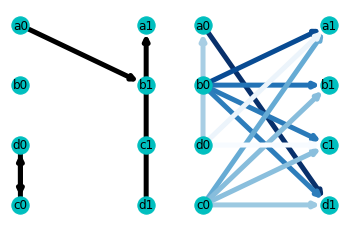

In [36]:
graph_y = None
graph_p = None

graph_y = nx.DiGraph()
graph_p = nx.DiGraph()

graph_y.add_nodes_from(range(nnodes*2))
graph_p.add_nodes_from(range(nnodes*2))

graph_y.add_edges_from(y_edges)
graph_p.add_edges_from(p_edges)

nodes_names = {f:'n' + str(f) for f in range(nnodes)}
rnodes = [v + '_t0' for _, v in nodes_names.items()]

nodes_names.update({k:v + '_t0' for k, v in nodes_names.items()})
nodes_names.update({k + len(nodes_names):v[:-1] + '1' for k, v in nodes_names.items()})

graph_y = nx.relabel_nodes(graph_y, nodes_names, copy=False)
graph_p = nx.relabel_nodes(graph_p, nodes_names, copy=False)

#pos = nx.shell_layout(graph_y, nlist=[range(nnodes),range(nnodes,nnodes*2)], rotate=0.1, center=(1,5))
pos = nx.bipartite_layout(graph_y, nodes=rnodes)

subax1 = plt.subplot(121)
nx.draw(graph_y, pos, node_color='c', edge_color='k', width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)

subax2 = plt.subplot(122)
nx.draw(graph_p, pos, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

## testing with real data

In [ ]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

test_dataset = CustomDataset(dst, nnodes, n_qubits, transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)

In [ ]:
experiments = []
outputs_list = []
for batch_features, _ in test_loader:
    batch_features = batch_features.view(-1, input_size)
    batch_features
    outputs = model(batch_features)
    outputs_list.append(outputs)
    experiments.append(np.flip(np.argsort(outputs.detach().numpy())))

In [ ]:
ol = [o.detach().numpy() for o in outputs_list]

In [ ]:
results_list = np.mean(np.array(ol), axis=0)
norm_results_list = scale(results_list, np.min(results_list), np.max(results_list)).astype(float)
results = np.flip(np.argsort(results_list))

In [ ]:
np.max(sum(outputs_list).detach().numpy()),np.min(sum(outputs_list).detach().numpy())

In [ ]:
results_bin = [np.binary_repr(f, width=n_qubits) for f in results.tolist()[0]]

In [ ]:
results_weights = [norm_results_list[0][results[0][i]] for i in range(len(results[0]))]

In [ ]:
results.tolist()[0][:num_res]

In [ ]:
results_bin[:num_res]

In [ ]:
p_edges = get_edges_array(n_qubits,results.tolist()[0][:num_res]) 
p_weights = results_weights[:num_res]

In [ ]:
graph_p = None
graph_p2 = None

graph_p = nx.DiGraph()
graph_p2 = nx.DiGraph()

graph_p.add_nodes_from(range(nnodes*2))
graph_p2.add_nodes_from(range(nnodes*2))

graph_p.add_edges_from(p_edges)
graph_p2.add_edges_from(p_edges)

rnodes = [v + '_t0' for _, v in nodes_names.items()]
rgenes = [v + '_t0' for _, v in genes_names.items()]

nodes_names.update({k:v + '_t0' for k, v in nodes_names.items()})
nodes_names.update({k + len(nodes_names):v[:-1] + '1' for k, v in nodes_names.items()})

genes_names.update({k:v + '_t0' for k, v in genes_names.items()})
genes_names.update({k + len(genes_names):v[:-1] + '1' for k, v in genes_names.items()})

graph_p = nx.relabel_nodes(graph_p, nodes_names, copy=False)
graph_p2 = nx.relabel_nodes(graph_p2, genes_names, copy=False)

#pos = nx.shell_layout(graph_y, nlist=[range(nnodes),range(nnodes,nnodes*2)], rotate=0.1, center=(1,5))
pos = nx.bipartite_layout(graph_p, nodes=rnodes)
pos2 = nx.bipartite_layout(graph_p2, nodes=rgenes)

subax1 = plt.subplot(121)
nx.draw(graph_p, pos, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)

subax2 = plt.subplot(122)
nx.draw(graph_p2, pos2, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()